In [12]:
!pip install pipenv
!pipenv sync --dev
!pipenv run pip freeze > requirements.txt


Installing dependencies from Pipfile.lock (eb9976)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.
All dependencies are now up-to-date!


In [13]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 957.2/957.2 kB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.0/752.0 kB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 29

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


In [3]:
urls = search_images('dog photos', max_images=1)
urls[0]

'http://photographyblogger.net/wp-content/uploads/2017/06/Cute-Puppy-Looks-Up.jpg'

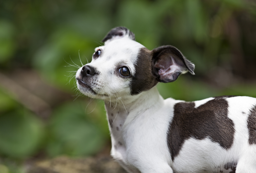

In [5]:
from fastdownload import download_url
dest = 'dog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

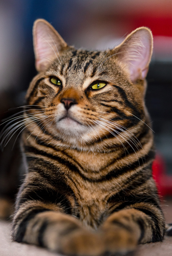

In [6]:
download_url(search_images('cat photos', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256,256)

In [13]:
searches = ['dog', 'cat']
path = Path('images')
from time import sleep

for term in searches:
    dest = (path/term)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{term} photo'))

    resize_images(path/term, max_size=400, dest=dest)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Train the mustache model

Cleanup bad images.

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

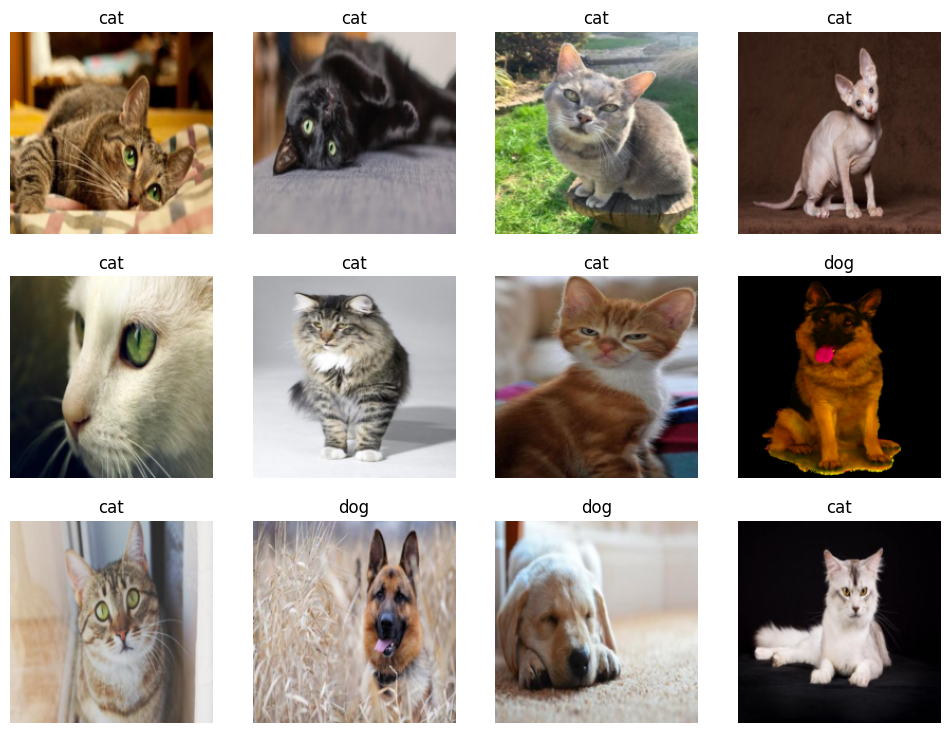

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=3),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=12)

In [18]:
import warnings
warnings.filterwarnings('ignore')


learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.103539,0.236755,0.080000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.247001,0.155624,0.093333,00:01
1,0.154523,0.137495,0.040000,00:01
2,0.122296,0.152651,0.040000,00:01
3,0.093868,0.135832,0.026667,00:01
4,0.074630,0.121993,0.026667,00:01


### Test out the model

Let's see what our model thinks about that mustache photo we downloaded at the start:

This is a: dog.
Probability it's a cat: 0.0015
Probability it's a dog: 0.9985


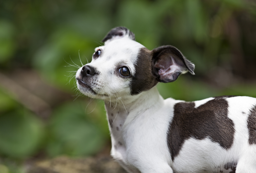

In [26]:
is_dog,_,probs = learn.predict(PILImage.create('dog.jpg'))

probabilities = dict(zip(learn.dls.vocab, probs))

print(f"This is a: {is_dog}.")

# iterate through probabilitites and print them
for key, value in probabilities.items():
    print(f"Probability it's a {key}: {value:.4f}")

im = Image.open('dog.jpg')
im.to_thumb(256,256)


This is a: cat.
Probability it's a cat: 1.0000
Probability it's a dog: 0.0000


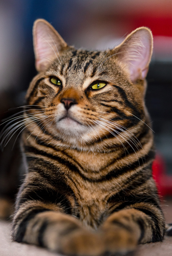

In [27]:
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))

probabilities = dict(zip(learn.dls.vocab, probs))

print(f"This is a: {is_cat}.")

# iterate through probabilitites and print them
for key, value in probabilities.items():
    print(f"Probability it's a {key}: {value:.4f}")

im = Image.open('cat.jpg')
im.to_thumb(256,256)
